<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#현재-상태" data-toc-modified-id="현재-상태-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>현재 상태</a></span></li><li><span><a href="#MLP-Regressor로-모델링-시도" data-toc-modified-id="MLP-Regressor로-모델링-시도-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MLP Regressor로 모델링 시도</a></span><ul class="toc-item"><li><span><a href="#구분-유형으로-나누어서-MLP-Regressor" data-toc-modified-id="구분-유형으로-나누어서-MLP-Regressor-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>구분 유형으로 나누어서 MLP Regressor</a></span></li></ul></li><li><span><a href="#PCA로-차원축소" data-toc-modified-id="PCA로-차원축소-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PCA로 차원축소</a></span><ul class="toc-item"><li><span><a href="#적절한-주성분-개수-설정" data-toc-modified-id="적절한-주성분-개수-설정-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>적절한 주성분 개수 설정</a></span></li><li><span><a href="#PCA-수행후-모델-성능-재점검" data-toc-modified-id="PCA-수행후-모델-성능-재점검-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PCA 수행후 모델 성능 재점검</a></span></li></ul></li><li><span><a href="#MLP-Regressor" data-toc-modified-id="MLP-Regressor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MLP Regressor</a></span></li></ul></div>

### 현재 상태

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import pymysql
import warnings
warnings.filterwarnings(action='ignore')

def get_NMAE(true, pred):
    mae = np.abs(true-pred)/true
    nmae = round(np.mean(mae), 3)
    return nmae

def load_datasets(path) -> pd.DataFrame:
    train = pd.read_csv(os.path.join(path, '한국가스공사_시간별 공급량_20181231.csv'),
                        encoding='cp949')
    test = pd.read_csv(os.path.join(path, 'test.csv'))
    # test 데이터 전처리
    test['연월일'] = test['일자|시간|구분'].str.split(' ', expand=True)[0]
    test['시간'] = test['일자|시간|구분'].str.split(' ', expand=True)[1].astype(int)
    test['구분'] = test['일자|시간|구분'].str.split(' ', expand=True)[2]
    del test['일자|시간|구분']

    data = pd.concat([train, test], axis=0)
    data['연월일'] = pd.to_datetime(data['연월일'])
    return data

def load_weather() -> pd.DataFrame:
    db = pymysql.connect(host='localhost', port=3306, user='younghun', password='watson1259',
                        db='dacon_gas_weather_db', charset='utf8')
    cursor = db.cursor()
    sql = "SELECT datetime, avg_temp, min_temp, max_temp,\
              NULLIF(sum_rain, '') as sum_rain, avg_wind, avg_humid,\
              sum_gsr, NULLIF(ddmefs, '') as ddmefs, avg_ts \
              FROM weather ORDER BY datetime"
    
    weather = pd.read_sql(sql, db)
    weather = weather.fillna(0.)
    
    return weather
    
def merge_gas_weather(path):
    gas = load_datasets(path)
    weather = load_weather()
    gas_weather = gas.merge(weather, how='left', left_on='연월일', right_on='datetime')
    del gas_weather['datetime']
    
    return gas_weather

def make_datetime_vars(data) -> pd.DataFrame:
    data['year'] = data['연월일'].dt.year
    data['month'] = data['연월일'].dt.month
    data['day'] = data['연월일'].dt.day
    #data['week_no'] = data['연월일'].dt.strftime("%V").astype(int)
    data['dayofweek'] = data['연월일'].dt.dayofweek
    data['weekend_yn'] = np.where(data['dayofweek'].isin(['Saturday', 'Sunday']), 1, 0)
    #data['dayofyear'] = data['연월일'].dt.dayofyear

    return data


def change_dates(row):
    if row['시간'] == 24:
        row['연월일'] += pd.DateOffset(days=1)
        row['시간'] = 0
    return row


def change_pandas_date_format(df):
    """ 연월일 날짜 포맷 바꾸기"""
    df = df.apply(change_dates, axis=1)
    df['시간'] = df['시간'].apply(lambda x: str(x) if x >= 10 else '0' + str(x))
    df['연월일'] = df['연월일'].astype(str)
    df['datetime'] = df['연월일'] + ' ' + df['시간']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H')

    df['prev_datetime'] = df['datetime'] - pd.DateOffset(years=1)

    return df


def make_autocorr_vars(df, gubun='A'):
    sub_df = df[df['구분'] == gubun]
    # 일년 전 그 시간대 공급량
    sub_df['prev_year_공급량'] = sub_df.groupby([sub_df['datetime'].dt.month, sub_df['datetime'].dt.day,
                                          sub_df['datetime'].dt.hour])['공급량'].shift()
#     # 이년 전 공급량 파생변수 생성
#     sub_df['prev_two_year_공급량'] = sub_df.groupby([sub_df['datetime'].dt.month, sub_df['datetime'].dt.day,
#                                               sub_df['datetime'].dt.hour])['공급량'].shift(2)
    #===============
    #일년 전 평균 공급량
    #===============
    sub_df['prev_year'] = sub_df['prev_datetime'].dt.year
    prev_year_mean_df = sub_df.groupby([sub_df['datetime'].dt.year])['공급량'].mean()
    prev_year_mean_dict = dict(zip(prev_year_mean_df.index, prev_year_mean_df.values.reshape(-1, )))
    sub_df['prev_year_avg_공급량'] = sub_df['prev_year'].map(prev_year_mean_dict)
    #====================
    # 일년 전 월별 평균 공급량
    #====================
    prev_month_mean_df = sub_df.groupby([sub_df['datetime'].dt.year, sub_df['datetime'].dt.month])['공급량'].mean()
    prev_month_mean_dict = dict(zip(prev_month_mean_df.index, prev_month_mean_df.values.reshape(-1, )))
    sub_df['prev_year_month'] = tuple(zip(sub_df['prev_year'].values.reshape(-1, ),
                                        sub_df['prev_datetime'].dt.month.values.reshape(-1, )))
    sub_df['prev_month_avg_공급량'] = sub_df['prev_year_month'].map(prev_month_mean_dict)
    #=======================
    # 일년 전 월-일자별 평균 공급량
    #=======================
    prev_month_day_mean_df = sub_df.groupby([sub_df['datetime'].dt.year,
                                           sub_df['datetime'].dt.month,
                                           sub_df['datetime'].dt.day])['공급량'].mean()
    prev_month_day_mean_dict = dict(zip(prev_month_day_mean_df.index, prev_month_day_mean_df.values.reshape(-1, )))

    sub_df['prev_year_month_day'] = tuple(zip(sub_df['prev_year'].values.reshape(-1, ),
                                            sub_df['prev_datetime'].dt.month.values.reshape(-1, ),
                                            sub_df['prev_datetime'].dt.day.values.reshape(-1, )))
    sub_df['prev_month_day_avg_공급량'] = sub_df['prev_year_month_day'].map(prev_month_day_mean_dict)
    #========================
    # 일년 전 월-시간 별 평균 공급량
    #========================
    prev_month_hour_mean_df = sub_df.groupby([sub_df['datetime'].dt.year,
                                            sub_df['datetime'].dt.month,
                                            sub_df['datetime'].dt.hour])['공급량'].mean()
    prev_month_hour_mean_dict = dict(zip(prev_month_hour_mean_df.index, prev_month_hour_mean_df.values.reshape(-1, )))

    sub_df['prev_year_month_hour'] = tuple(zip(sub_df['prev_year'].values.reshape(-1, ),
                                             sub_df['prev_datetime'].dt.month.values.reshape(-1, ),
                                             sub_df['prev_datetime'].dt.hour.values.reshape(-1, )))
    sub_df['prev_month_hour_avg_공급량'] = sub_df['prev_year_month_hour'].map(prev_month_hour_mean_dict)
    #==============
    # 증가율 변수 생성
    #==============
    sub_df['prev_year_ratio'] = (sub_df['prev_year_공급량']-sub_df['prev_year_avg_공급량'])/sub_df['prev_year_avg_공급량']
    sub_df['prev_month_ratio'] = (sub_df['prev_year_공급량']-sub_df['prev_month_avg_공급량'])/sub_df['prev_month_avg_공급량']
    sub_df['prev_month_day_ratio'] = (sub_df['prev_year_공급량']-sub_df['prev_month_day_avg_공급량'])/sub_df['prev_month_day_avg_공급량']
    sub_df['prev_month_hour_ratio'] = (sub_df['prev_year_공급량']-sub_df['prev_month_hour_avg_공급량'])/sub_df['prev_month_hour_avg_공급량']
    #========================
    # 일년 전 그 날의 기상 변수 FE
    #========================
    weather_cols = ['avg_temp','min_temp','max_temp','sum_rain','avg_wind','avg_humid','sum_gsr','ddmefs','avg_ts']
    for col in weather_cols:
        sub_df[f'prev_year_{col}'] = sub_df.groupby([sub_df['datetime'].dt.month, sub_df['datetime'].dt.day,
                                                  sub_df['datetime'].dt.hour])[col].shift()
        sub_df[f'prev_year_{col}'] = pd.to_numeric(sub_df[f'prev_year_{col}'], downcast="float")
    #================
    # 필요한 칼럼들만 추출
    #================
    used_cols = ['연월일', '시간', '구분', 'datetime',
#                  'year', 'month', 'day', 'week_no','dayofweek','weekend_yn',
                 'prev_year_공급량', 'prev_year_avg_공급량','prev_month_avg_공급량', 'prev_month_day_avg_공급량', 'prev_month_hour_avg_공급량',
                 'prev_year_ratio','prev_month_ratio','prev_month_day_ratio','prev_month_hour_ratio']
    #weather_cols = [f'prev_year_{col}' for col in weather_cols]
    #used_cols += weather_cols + ['공급량']
    used_cols += ['공급량']
    sub_df = sub_df[used_cols]
    
    return sub_df


def fe_autocorr_vars(df):
    final_df = pd.DataFrame()
    gubun_cols = ['A','B','C','D','E','G','H']
    for gubun in tqdm(gubun_cols):
        sub_df = make_autocorr_vars(df, gubun=gubun)
        final_df = pd.concat([final_df, sub_df], axis=0)
    # 제거할 칼럼들
    final_df = final_df.drop(['prev_year_avg_공급량', 'prev_month_hour_ratio'], axis=1)
    return final_df

def change_dates_adversely(row):
    if row['datetime'].hour == 0:
        row['연월일'] -= pd.DateOffset(days=1)
        row['시간'] = 24
    return row

def change_date_format(df):
    df['연월일'] = pd.to_datetime(df['연월일'])
    df['시간'] = df['시간'].astype(int)
    df = df.apply(change_dates_adversely, axis=1)
    
    del df['datetime']
    
    return df


# 추가 FE 하는 함수 -> 2018년까지의 평균값을 2019년에 집어넣어야 함!
def fe_avg_vars(final_df):
    main_df = pd.DataFrame()
    cols = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
    for gubun in tqdm(cols):
        sub_df = final_df[final_df['구분'] == gubun]
        ## 단, FE 계산 때는 2018년까지의 Train 데이터만 사용, FE 적용은 Train, Test 모두에 적용
        #===============
        # 1.월별 평균 공급량
        #===============
        fe_df = sub_df[sub_df['연월일'].dt.year < 2019]
        group = fe_df.groupby([fe_df['연월일'].dt.month]).agg({'공급량':'mean'}) # Train만 사용
        month_avg_dict = dict(zip(group.index, group.values.reshape(-1,)))
        sub_df['month_avg'] = sub_df['연월일'].dt.month.map(month_avg_dict)    # Train, Test에 모두 적용
        #==================
        # 2. 월-일별 평균 공급량
        #==================
        group = fe_df.groupby([fe_df['연월일'].dt.month, fe_df['연월일'].dt.day]).agg({'공급량':'mean'})
        group_dict1 = dict(zip(group.index, group.values.reshape(-1,)))
        # 임시 변수 생성
        sub_df['month-day_tuple'] = tuple(zip(sub_df['연월일'].dt.month.values.reshape(-1,),
                                              sub_df['연월일'].dt.day.values.reshape(-1,)))
        # 임시 변수 기반으로 group_dict 매핑
        sub_df['month_day_avg'] = sub_df['month-day_tuple'].map(group_dict1)
        del sub_df['month-day_tuple']
        #======================
        # 3. 월-일-시간별 평균 공급량
        #======================
        group = fe_df.groupby([fe_df['연월일'].dt.month, fe_df['연월일'].dt.day, fe_df['시간']])\
                     .agg({'공급량': 'mean'})
        group_dict2 = dict(zip(group.index, group.values.reshape(-1,)))
        # 임시 변수 생성
        sub_df['month-day-hr_tuple'] = tuple(zip(sub_df['연월일'].dt.month.values.reshape(-1,),
                                                  sub_df['연월일'].dt.day.values.reshape(-1,),
                                                  sub_df['시간'].values.reshape(-1,)))
        # 임시 변수 기반으로 group_dict 매핑
        sub_df['month_day_hr_avg'] = sub_df['month-day-hr_tuple'].map(group_dict2)
        del sub_df['month-day-hr_tuple']
        #=========================================
        # 3. 월별 평균 공급량 대비 월-일별 평균 공급량 증감률
        #=========================================
        sub_df['month_month-day_ratio'] = (sub_df['month_day_avg']-sub_df['month_avg'])/sub_df['month_avg']
        #=============================================
        # 4. 월별 평균 공급량 대비 월-일-시간별 평균 공급량 증감률
        #=============================================
        sub_df['month_month-day-hr_ratio'] = (sub_df['month_day_hr_avg']-sub_df['month_avg'])/sub_df['month_avg']
        #===============================================
        # 5. 월-일별 평균 공급량 대비 월-일-시간별 평균 공급량 증감률
        #===============================================
        sub_df['month-day_month-day-hr_ratio'] = (sub_df['month_day_hr_avg']-sub_df['month_day_avg'])/sub_df['month_day_avg']
        
        
        # sub_df를 main_df에 결합
        main_df = pd.concat([main_df, sub_df], axis=0)
    
    # 칼럼 순서 맞추기
    cols_order = main_df.columns.tolist()
    cols_order.remove('공급량')
    cols_order.insert(len(cols_order), '공급량')
    main_df = main_df[cols_order]
        
    return main_df

In [2]:
path = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas'
gas_weather = merge_gas_weather(path)
dataset = make_datetime_vars(gas_weather)
dataset = change_pandas_date_format(dataset)
dataset = fe_autocorr_vars(dataset)
dataset = change_date_format(dataset)
final_df = fe_avg_vars(dataset)
final_df = final_df.reset_index(drop=True)

print(final_df.shape)

100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

(383208, 17)


In [46]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import time

def predict_scaling_ftr(final_df, model, submission_csv):
    cols = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
    all_pred = np.array([])
    for gubun in tgdqm(cols):
        st = time.time()
        sub_df = final_df[final_df['구분'] == gubun]
        sub_df = sub_df.set_index(['연월일', '시간', '구분'])
        idx_level = sub_df.index.get_level_values
        
        train = sub_df[(idx_level(0) < '2018-09-01')].fillna(method='ffill')
        valid = sub_df[(idx_level(0) >= '2018-09-01')&(idx_level(0) <= '2018-12-31')].fillna(method='ffill')
        
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_valid, y_valid = valid.iloc[:, :-1].values, valid['공급량']
        # Scaling feature
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        # fit model
        #model = model_dict[gubun]
        model.fit(X_train, y_train)
        # predict
        train_pred = model.predict(X_train)
        valid_pred = model.predict(X_valid)
        # evaluate
        train_NMAE = get_NMAE(y_train, train_pred)
        valid_NMAE = get_NMAE(y_valid, valid_pred)
        print(f'# 유형({gubun}) - Train NMAE: {train_NMAE: .4f}')
        print(f'# 유형({gubun}) - Valid NMAE: {valid_NMAE: .4f}')
        print(f'# 학습 시간: {time.time() - st: .2f}초')
        print()
        
        # 다시 Train, Test로 분할
        train = sub_df[(idx_level(0) < '2019-01-01')].fillna(method='ffill')
        test = sub_df[(idx_level(0) >= '2019-01-01')].fillna(method='ffill')
        
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_test = test.iloc[:, :-1].values
        # Scaling
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # fit model
        #model = model_dict[gubun]
        model.fit(X_train, y_train)
        # predict
        test_pred = model.predict(X_test)
        all_pred = np.append(all_pred, test_pred)
    submission_csv['공급량'] = all_pred
    return submission_csv

In [115]:
import os
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor


# model
lgbm_reg = LGBMRegressor(n_estimators=100, random_state=42)
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
hybrid_reg = VotingRegressor([('lgbm', lgbm_reg), ('xgb', xgb_reg)])

# submission csv
dirname = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas'
sub_csv = pd.read_csv(os.path.join(dirname, 'sample_submission.csv'))

# predict
pred_csv = predict_scaling_ftr(final_df=final_df, model=hybrid_reg, submission_csv=sub_csv)

[14:44:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(A) - Train NMAE:  0.1000
# 유형(A) - Valid NMAE:  0.1400

[14:44:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(B) - Train NMAE:  0.1050
# 유형(B) - Valid NMAE:  0.1410

[14:44:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(C) - Train NMAE:  0.9540
# 유형(C) - Valid NMAE:  0.2610

[14:44:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(

In [5]:
# 일변량으로 Kats Prophet 사용
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

def date_format_pandas(row):
    if row['시간'] == 24:
        row['연월일'] += pd.DateOffset(days=1)
        row['시간'] = 0
    return row

def prophet(final_df, gubun):
    gubun_df = final_df[final_df['구분'] == gubun]
    gubun_df = gubun_df.apply(date_format_pandas, axis=1)
    gubun_df['시간'] = gubun_df['시간'].apply(lambda x: str(x) if x >= 10 else '0'+str(x))
    gubun_df['연월일'] = gubun_df['연월일'].astype(str)
    gubun_df['time'] = gubun_df['연월일'] + ' ' + gubun_df['시간']
    gubun_df['time'] = pd.to_datetime(gubun_df['time'], format='%Y-%m-%d %H')
    
    # Train, Valid 분할
    train = gubun_df[gubun_df['time'] <= '2019-01-01 00:00:00']
    test = gubun_df[(gubun_df['time'] > '2019-01-01 00:00:00')]
    # TimeSeries 객체로 변환
    uni_df = train[['time', '공급량']]
    uni_ts = TimeSeriesData(uni_df)
    # params
    params = ProphetParams(seasonality_mode='additive')
    # model
    prophet = ProphetModel(uni_ts, params=params)
    # fit
    prophet.fit()
    # predict
    test_pred = prophet.predict(steps=test.shape[0], freq='H')
    print('test_pred shape:', test_pred.shape)
    return test_pred

def merge_pred_csv_prophet_csv(final_df, pred_csv, gubun='C'):
    """
    pred_csv : 일반 머신러닝 모델로 예측한 Test 데이터 결과값이 담긴 panadas.dataframe
    test_pred : Prophet으로 특정 유형에 대해 예측한 결과값이 담긴 panadas.dataframe
    """
    test_pred = prophet(final_df, gubun)
    
    pred_csv['일자'] = pred_csv['일자|시간|구분'].str.split(' ', expand=True)[0]
    pred_csv['시간'] = pred_csv['일자|시간|구분'].str.split(' ', expand=True)[1]
    pred_csv['구분'] = pred_csv['일자|시간|구분'].str.split(' ', expand=True)[2]
    pred_csv['일자'] = pd.to_datetime(pred_csv['일자'])
    pred_csv['시간'] = pred_csv['시간'].astype(int)
    
    final_csv = pred_csv[pred_csv['구분'] != gubun]
    gubun_csv = pred_csv[pred_csv['구분'] == gubun]
    gubun_csv['공급량'] = test_pred['fcst'].values
    final_csv = pd.concat([final_csv, gubun_csv], axis=0)
    columns = ['구분', '일자', '시간']
    final_csv = final_csv.sort_values(by=columns)
    final_csv = final_csv.drop(columns, axis=1)
    return final_csv

In [ ]:
# 특정 유형만 Prophet으로 예측하는 함수

sub_csv = merge_pred_csv_prophet_csv(final_df=final_df, pred_csv=pred_csv, gubun='C')

In [123]:
save_name = 'submission/0103False_SimulFalse_xgb+lgbm_cols-autocorr_extra_vars_MinMaxscale_exclude_datetime_C_prophet.csv'
sub_csv.to_csv(os.path.join(dirname, save_name), index=False)

- 오버피팅 발생... -> 차원의 수를 줄여야 할 듯 싶다..
- PLS, PCA 활용해서 차원 감소 후 시도
- 딥러닝 시도
    - MLPRegressor
    - Tensorflow

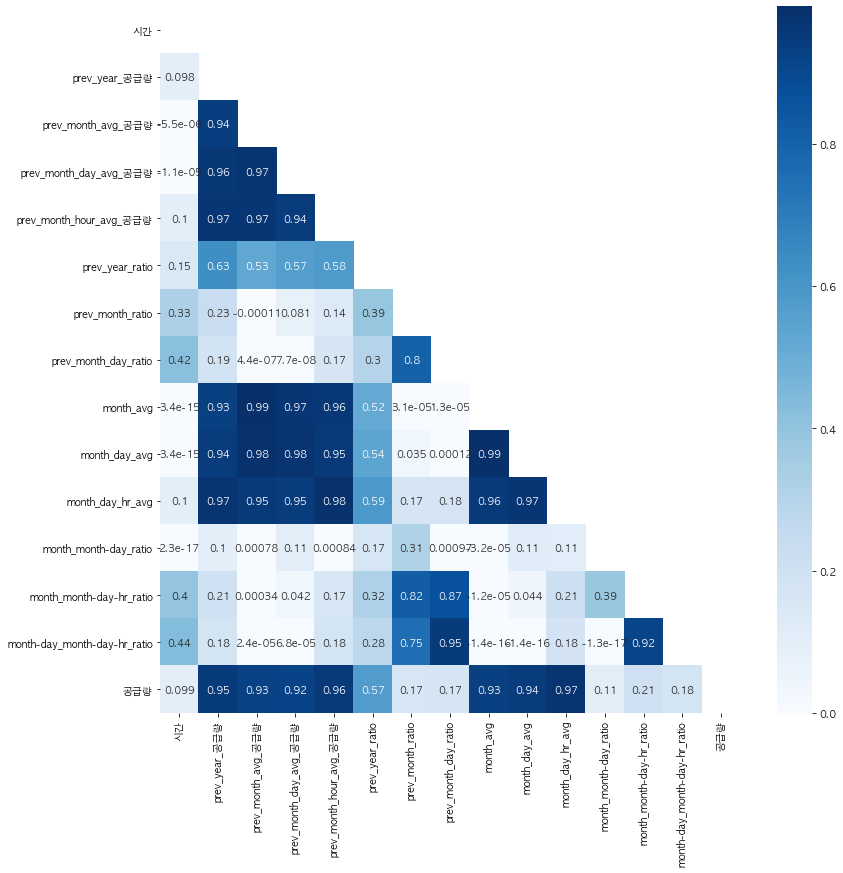

In [7]:
# 추가된 변수들 공급량과의 상관관계 살펴보기
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')

corr_df = final_df.corr()
mask = np.triu(corr_df)

plt.figure(figsize=(13, 13))
sns.heatmap(corr_df, annot=True, cmap='Blues', mask=mask)
plt.show()

In [4]:
# 가장 성능 좋았던(0.126)의 변수들 정의
best_cols = ['연월일', '시간', '구분', 'prev_year_공급량', 'prev_month_avg_공급량', 'prev_month_day_avg_공급량',
            'prev_month_hour_avg_공급량', 'prev_year_ratio', 'prev_month_ratio', 'prev_month_day_ratio',
            '공급량']
cond2014 = (final_df['연월일'].dt.year > 2013)

final_df = final_df[cond2014]

### MLP Regressor로 모델링 시도
- 기본적으로 딥러닝은 비선형으로 이루어진 데이터에 대해 적합..
- 기본적으로 딥러닝은 데이터가 많을수록 좋긴 해..
- 구분 유형 1개당은 5.2만개 
- 구분 유형 없이 전체라고 한다면 36.8만개
- 둘 중 어떤 모델이 더 좋을까?

#### 구분 유형으로 나누어서 MLP Regressor 
- 시간 너무 오래걸림데스..

In [ ]:
# from sklearn.neural_network import MLPRegressor
# import os

# # model
# mlp_reg = MLPRegressor(activation='relu', alpha=0.005, learning_rate_init=0.001,
#                       hidden_layer_sizes=(256, 64, 4), max_iter=500)
# # submission csv
# dirname = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas'
# sub_csv = pd.read_csv(os.path.join(dirname, 'sample_submission.csv'))

# train = predict_scaling_ftr(final_df=final_df[best_cols], model=mlp_reg, submission_csv=sub_csv)

# 유형(A) - Train NMAE:  0.1500
# 유형(A) - Valid NMAE:  0.1790



### PCA로 차원축소
#### 적절한 주성분 개수 설정

A 유형에 대한 PCA 결과


,고윳값,기여율,누적기여율
pca1,4.865317,0.695030,0.695030
pca2,1.828235,0.261171,0.956201
pca3,0.237822,0.033974,0.990175
pca4,0.041246,0.005892,0.996067
pca5,0.017988,0.002570,0.998637
pca6,0.006130,0.000876,0.999512
pca7,0.003413,0.000488,1.000000


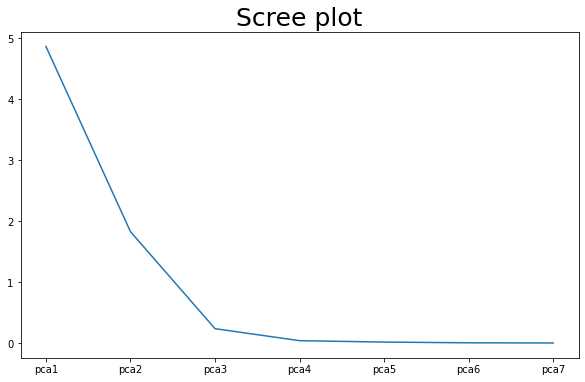



B 유형에 대한 PCA 결과


,고윳값,기여율,누적기여율
pca1,4.865427,0.695046,0.695046
pca2,1.853172,0.264733,0.959779
pca3,0.203694,0.029098,0.988877
pca4,0.050565,0.007223,0.996101
pca5,0.018222,0.002603,0.998704
pca6,0.005976,0.000854,0.999558
pca7,0.003096,0.000442,1.000000


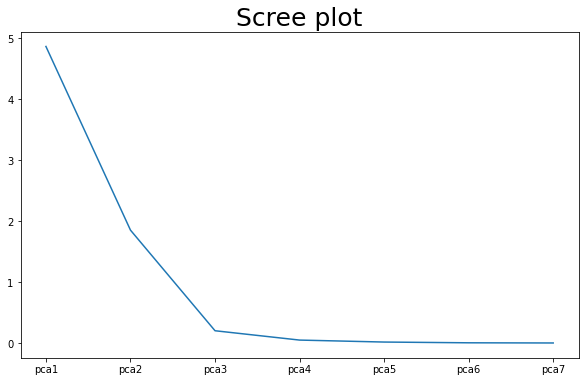



C 유형에 대한 PCA 결과


,고윳값,기여율,누적기여율
pca1,4.784279,0.683453,0.683453
pca2,1.424320,0.203470,0.886923
pca3,0.672414,0.096057,0.982980
pca4,0.065122,0.009303,0.992283
pca5,0.035022,0.005003,0.997286
pca6,0.016011,0.002287,0.999574
pca7,0.002985,0.000426,1.000000


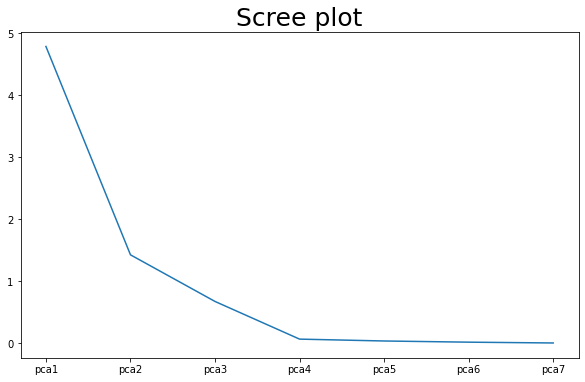



D 유형에 대한 PCA 결과


,고윳값,기여율,누적기여율
pca1,4.879276,0.697024,0.697024
pca2,1.842286,0.263178,0.960202
pca3,0.206619,0.029516,0.989719
pca4,0.047551,0.006793,0.996511
pca5,0.016926,0.002418,0.998929
pca6,0.004991,0.000713,0.999642
pca7,0.002504,0.000358,1.000000


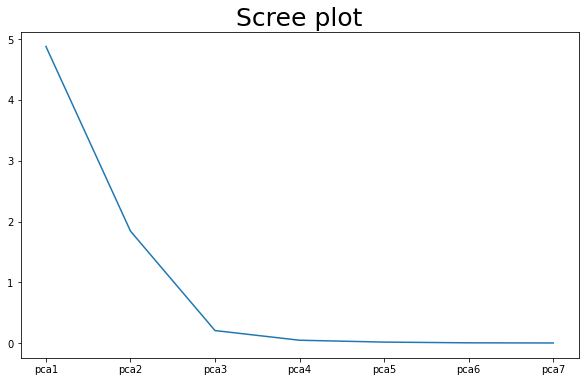



E 유형에 대한 PCA 결과


,고윳값,기여율,누적기여율
pca1,4.879141,0.697005,0.697005
pca2,1.839557,0.262788,0.959793
pca3,0.213683,0.030525,0.990319
pca4,0.043299,0.006185,0.996504
pca5,0.016234,0.002319,0.998823
pca6,0.005702,0.000815,0.999638
pca7,0.002536,0.000362,1.000000


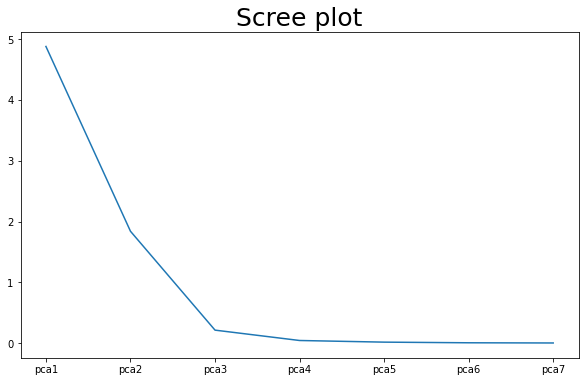



G 유형에 대한 PCA 결과


,고윳값,기여율,누적기여율
pca1,4.855815,0.693673,0.693673
pca2,1.773552,0.253359,0.947032
pca3,0.306229,0.043746,0.990778
pca4,0.033907,0.004844,0.995622
pca5,0.019475,0.002782,0.998404
pca6,0.007246,0.001035,0.999439
pca7,0.003928,0.000561,1.000000


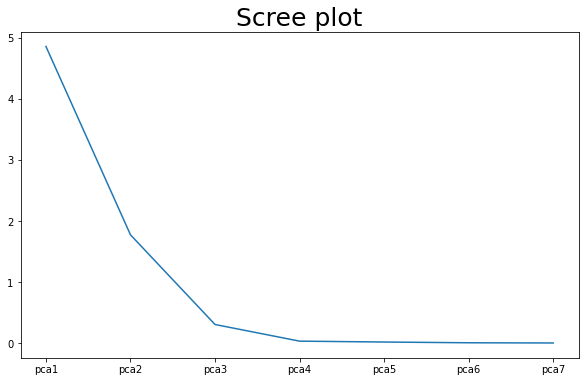



H 유형에 대한 PCA 결과


,고윳값,기여율,누적기여율
pca1,4.818385,0.688326,0.688326
pca2,1.816843,0.259543,0.947869
pca3,0.251920,0.035988,0.983857
pca4,0.061623,0.008803,0.992660
pca5,0.035065,0.005009,0.997669
pca6,0.013406,0.001915,0.999584
pca7,0.002910,0.000416,1.000000


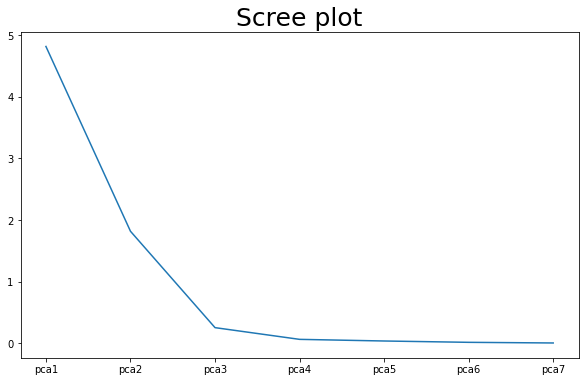

In [48]:
# 구분유형 별로 PCA 적절한 개수 살펴보기
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_gubun(final_df):
    gubuns = final_df['구분'].unique()
    for gubun in gubuns:
        sub_df = final_df[final_df['구분'] == gubun]
        pca_cols = sub_df.columns.tolist()[3:-1]
        pca_df = sub_df[pca_cols].fillna(method='ffill')
        # Scaling
        scaled_df = pd.DataFrame(StandardScaler().fit_transform(pca_df), index=pca_df.index,
                                columns=pca_df.columns)
        # PCA
        pca = PCA(n_components=pca_df.shape[1])
        pca.fit_transform(scaled_df)
        pca_result = pd.DataFrame({'고윳값': pca.explained_variance_,
                                  '기여율': pca.explained_variance_ratio_},
                                 index=[f'pca{i}' for i in range(1, pca_df.shape[1]+1)])
        pca_result['누적기여율'] = pca_result['기여율'].cumsum()
        print(f'{gubun} 유형에 대한 PCA 결과')
        display(pca_result)
        # Scree plot
        plt.figure(figsize=(10, 6))
        plt.plot(pca_result.index, pca_result['고윳값'])
        plt.title("Scree plot", fontsize=25)
        plt.show()
        print()
        print()
        
pca_gubun(final_df=final_df[best_cols])        

- 모든 유형에 대해 적절한 주성분 개수 분석해본 결과, 주성분 2개 or 3개까지만 사용!

#### PCA 수행후 모델 성능 재점검


In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import time

def predict_scaling_ftr(final_df, model, submission_csv):
    cols = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
    all_pred = np.array([])
    for gubun in tqdm(cols):
        st = time.time()
        sub_df = final_df[final_df['구분'] == gubun]
        sub_df = sub_df.set_index(['연월일', '시간', '구분'])
        idx_level = sub_df.index.get_level_values
        #=================
        # Train, Valid 검증
        #=================
        train = sub_df[(idx_level(0) < '2018-09-01')].fillna(method='ffill')
        valid = sub_df[(idx_level(0) >= '2018-09-01')&(idx_level(0) <= '2018-12-31')].fillna(method='ffill')
        
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_valid, y_valid = valid.iloc[:, :-1].values, valid['공급량']
        # Scaling feature
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        
        # fit model
        #model = model_dict[gubun]
        model.fit(X_train, y_train)
        # predict
        train_pred = model.predict(X_train)
        valid_pred = model.predict(X_valid)
        # evaluate
        train_NMAE = get_NMAE(y_train, train_pred)
        valid_NMAE = get_NMAE(y_valid, valid_pred)
        print(f'# 유형({gubun}) - Train NMAE: {train_NMAE: .4f}')
        print(f'# 유형({gubun}) - Valid NMAE: {valid_NMAE: .4f}')
        print(f'# 학습 시간: {time.time() - st: .2f}초')
        print()
        #=========================
        # Train, Test 분할해 최종 예측
        #=========================
        train = sub_df[(idx_level(0) < '2019-01-01')].fillna(method='ffill')
        test = sub_df[(idx_level(0) >= '2019-01-01')].fillna(method='ffill')
        
        X_train, y_train = train.iloc[:, :-1].values, train['공급량']
        X_test = test.iloc[:, :-1].values
        # Scaling
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print('- Train csv shape:', X_train.shape, '- Test csv_shape:', X_test.shape)
        
        # fit model
        #model = model_dict[gubun]
        model.fit(X_train, y_train)
        # predict
        test_pred = model.predict(X_test)
        all_pred = np.append(all_pred, test_pred)
        
    submission_csv['공급량'] = all_pred
    return submission_csv

In [54]:
# PCA 3개(2개 보다 검증 성능이 더 좋음)
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# model
lgbm_reg = LGBMRegressor(n_estimators=100, random_state=42)
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
hybrid_reg = VotingRegressor([('lgbm', lgbm_reg), ('xgb', xgb_reg)])

# submission csv
dirname = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas'
sub_csv = pd.read_csv(os.path.join(dirname, 'sample_submission.csv'))

pred_csv = predict_scaling_ftr(final_df=final_df[best_cols], model=hybrid_reg, submission_csv=sub_csv)

  0%|          | 0/7 [00:00<?, ?it/s]

[13:15:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(A) - Train NMAE:  0.1460
# 유형(A) - Valid NMAE:  0.1720
# 학습 시간:  1.93초

[13:15:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 14%|█▍        | 1/7 [00:03<00:21,  3.60s/it]

[13:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(B) - Train NMAE:  0.1540
# 유형(B) - Valid NMAE:  0.1760
# 학습 시간:  1.87초

[13:15:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 29%|██▊       | 2/7 [00:07<00:18,  3.65s/it]

[13:15:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(C) - Train NMAE:  2.5730
# 유형(C) - Valid NMAE:  0.2690
# 학습 시간:  1.81초

[13:15:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 43%|████▎     | 3/7 [00:10<00:14,  3.57s/it]

[13:15:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(D) - Train NMAE:  0.1470
# 유형(D) - Valid NMAE:  0.1660
# 학습 시간:  1.81초

[13:15:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 57%|█████▋    | 4/7 [00:14<00:10,  3.57s/it]

[13:16:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(E) - Train NMAE:  0.1350
# 유형(E) - Valid NMAE:  0.1660
# 학습 시간:  1.83초

[13:16:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 71%|███████▏  | 5/7 [00:17<00:07,  3.59s/it]

[13:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(G) - Train NMAE:  0.1400
# 유형(G) - Valid NMAE:  0.1610
# 학습 시간:  1.81초

[13:16:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 86%|████████▌ | 6/7 [00:21<00:03,  3.56s/it]

[13:16:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(H) - Train NMAE:  0.1450
# 유형(H) - Valid NMAE:  0.1660
# 학습 시간:  1.82초

[13:16:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


In [55]:
filename = '0103False_SimulFalse_xgb+lgbm_autocorr(exclude_extra_vars)_PCA_Standard.csv'
pred_csv.to_csv(os.path.join(dirname, 'submission', filename), index=False)

In [61]:
# 새로 만든 칼럼만을 사용해보자
new_cols = final_df.columns.tolist()[:3] + final_df.columns.tolist()[-7:-4] + ['공급량']
new_cols

['연월일', '시간', '구분', 'month_avg', 'month_day_avg', 'month_day_hr_avg', '공급량']

In [64]:
# PCA 3개(2개 보다 검증 성능이 더 좋음) + best_cols로
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# model
lgbm_reg = LGBMRegressor(n_estimators=100, random_state=42)
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
hybrid_reg = VotingRegressor([('lgbm', lgbm_reg), ('xgb', xgb_reg)])

# submission csv
dirname = '/Users/younghun/Desktop/gitrepo/KaggleStruggle/dacon_gas'
sub_csv = pd.read_csv(os.path.join(dirname, 'sample_submission.csv'))

pred_csv = predict_scaling_ftr(final_df=final_df[new_cols], model=hybrid_reg, submission_csv=sub_csv)

  0%|          | 0/7 [00:00<?, ?it/s]

[13:21:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(A) - Train NMAE:  0.1210
# 유형(A) - Valid NMAE:  0.1470
# 학습 시간:  1.63초

- Train csv shape: (43824, 3) - Test csv_shape: (2160, 3)
[13:21:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 14%|█▍        | 1/7 [00:02<00:16,  2.83s/it]

[13:21:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(B) - Train NMAE:  0.1220
# 유형(B) - Valid NMAE:  0.1410
# 학습 시간:  1.49초

- Train csv shape: (43824, 3) - Test csv_shape: (2160, 3)
[13:21:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 29%|██▊       | 2/7 [00:05<00:13,  2.74s/it]

[13:21:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(C) - Train NMAE:  2.6750
# 유형(C) - Valid NMAE:  0.2020
# 학습 시간:  1.54초

- Train csv shape: (43824, 3) - Test csv_shape: (2160, 3)
[13:21:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 43%|████▎     | 3/7 [00:08<00:11,  2.79s/it]

[13:21:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(D) - Train NMAE:  0.1210
# 유형(D) - Valid NMAE:  0.1440
# 학습 시간:  1.49초

- Train csv shape: (43824, 3) - Test csv_shape: (2160, 3)
[13:21:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 57%|█████▋    | 4/7 [00:11<00:08,  2.79s/it]

[13:21:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(E) - Train NMAE:  0.1120
# 유형(E) - Valid NMAE:  0.1440
# 학습 시간:  1.56초

- Train csv shape: (43824, 3) - Test csv_shape: (2160, 3)
[13:21:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 71%|███████▏  | 5/7 [00:13<00:05,  2.80s/it]

[13:21:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(G) - Train NMAE:  0.1300
# 유형(G) - Valid NMAE:  0.1560
# 학습 시간:  1.45초

- Train csv shape: (43824, 3) - Test csv_shape: (2160, 3)
[13:21:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 86%|████████▌ | 6/7 [00:16<00:02,  2.76s/it]

[13:21:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# 유형(H) - Train NMAE:  0.1110
# 유형(H) - Valid NMAE:  0.1290
# 학습 시간:  1.49초

- Train csv shape: (43824, 3) - Test csv_shape: (2160, 3)
[13:21:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 7/7 [00:19<00:00,  2.77s/it]


In [65]:
filename = '0103False_SimulFalse_xgb+lgbm_autocorr(only_new_vars)_MinMaxscale.csv'
pred_csv.to_csv(os.path.join(dirname, 'submission', filename), index=False)

- 옛날 변수들만 가져가자..

### MLP Regressor

In [68]:
best_df = final_df[best_cols]
best_df.head()

,연월일,시간,구분,prev_year_공급량,prev_month_avg_공급량,prev_month_day_avg_공급량,prev_month_hour_avg_공급량,prev_year_ratio,prev_month_ratio,prev_month_day_ratio,공급량
8760,2014-01-01,1,A,2497.129,2599.321581,2505.690391,2377.634806,0.968475,-0.039315,-0.003417,1677.257
8761,2014-01-01,2,A,2363.265,2599.321581,2505.690391,2129.168742,0.862950,-0.090815,-0.056841,1567.057
8762,2014-01-01,3,A,2258.505,2599.321581,2505.690391,1994.322290,0.780369,-0.131118,-0.098650,1458.089
8763,2014-01-01,4,A,2243.969,2599.321581,2505.690391,2056.672484,0.768910,-0.136710,-0.104451,1458.449
8764,2014-01-01,5,A,2344.105,2599.321581,2505.690391,2235.652613,0.847847,-0.098186,-0.064487,1587.713
